In [1]:
import datetime
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from IPython.display import Markdown

# from matplotlib import style
import seaborn as sns
%matplotlib inline

# API settings and information import
from env import *
from nomics import Nomics
nomics = Nomics(key=api_key)

## Pull in the last 1000 days of BTC price on a daily basis

In [2]:
end = datetime.datetime.now(datetime.timezone.utc).isoformat()
start = (datetime.datetime.now(datetime.timezone.utc)
         - datetime.timedelta(days=1000)).isoformat()
daily_btc_df = pd.DataFrame(nomics.ExchangeRates.get_history(
currency='BTC',
start=start,
end=end))
daily_btc_df['date'] = pd.to_datetime(daily_btc_df.timestamp)
daily_btc_df = daily_btc_df.set_index(daily_btc_df.date).drop(columns=['date','timestamp'])

### Look at the BTC price on a daily basis for the last 1000 days

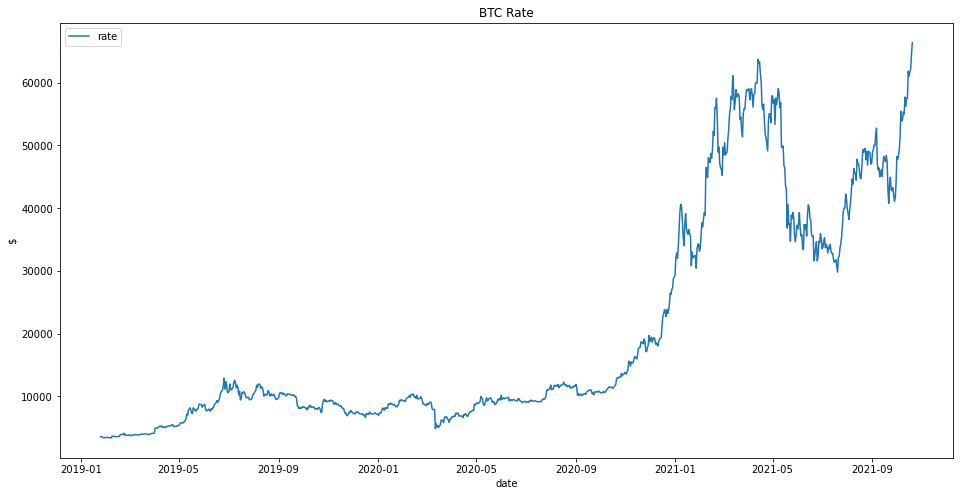

In [3]:
daily_btc_df.rate = pd.to_numeric(daily_btc_df.rate)
plt.figure(figsize=(16,8))
sns.lineplot(data=daily_btc_df).set(title = 'BTC Rate')
plt.ylabel('$')
plt.show()

In [4]:
daily_btc_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000 entries, 2019-01-25 00:00:00+00:00 to 2021-10-20 00:00:00+00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rate    1000 non-null   float64
dtypes: float64(1)
memory usage: 15.6 KB


### Take a look at the Exponentional Moving Averages at various intervals

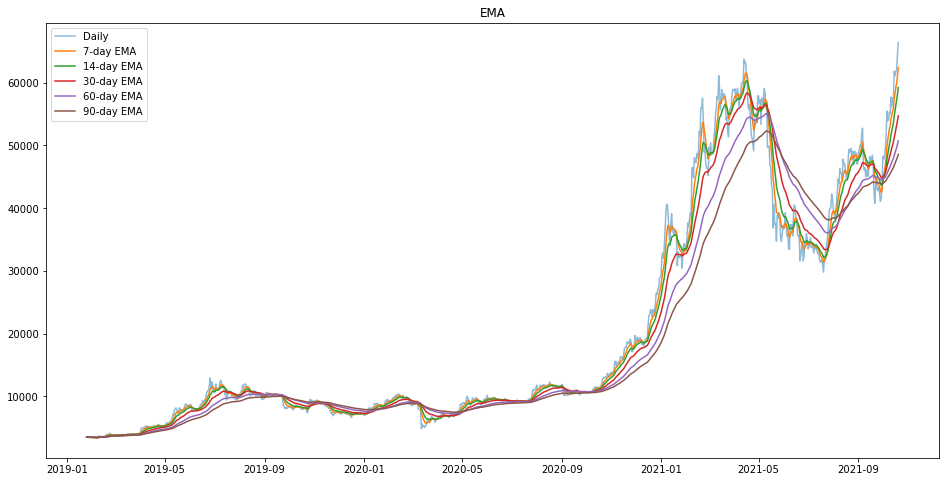

In [5]:
ema_lst = [7, 14, 30, 60, 90]

plt.figure(figsize=(16, 8))

plt.plot(daily_btc_df.index, daily_btc_df, label=f'Daily', alpha=.5)
for ema in ema_lst:
    ## Plot the Exponential Moving Average 
    # Plot the midband
    midband = daily_btc_df.ewm(span=ema).mean()
    plt.plot(daily_btc_df.index, midband, label=f'{ema}-day EMA')
    plt.legend(loc='best')
    plt.title('EMA')
plt.show()

In [6]:

def generateBollingerBands(df, ema_lst=[7, 14, 30, 60, 90]):
    '''Pass df with index that's DateTimeIndex and only one continuious column
    '''
    
    result = ''
    col_name = df.columns[0]
    
    def plotFigure(my_df, ema, col_name):
            plt.figure(figsize=(16,8))
            tmp_result = ''
            plt.plot(my_df.index, my_df.rate, label=col_name.title())
            plt.plot(my_df.index, my_df.midband, label=f'{ema}-day EMA/Midband')
            plt.plot(my_df.index, my_df.upper_band, label='Upper Band')
            plt.plot(my_df.index, my_df.lower_band, label='Lower Band')
            plt.legend(loc='best')
            plt.ylabel(col_name.title())
            plt.title(f'{ema} Day Bollinger Band for {col_name.title()}')
            figname = f'images/{ema}_day_bb_plot.png'
            tmp_result += f'#### {ema}-Day Bollinger Band Plot\n\n'
            tmp_result += f"![{ema}_day_bb_{col_name}_plt]({figname} '{ema}_day_bb_{col_name}_image')\n\n"
            plt.savefig(figname)
            plt.show()
            return tmp_result

    for ema in ema_lst: 
        # Calculate Midband
        midband = df.ewm(span=ema).mean()
        stdev = df.ewm(span=ema).std()
        upper_band = midband + stdev * 3
        lower_band = midband - stdev * 3
        bollinger_band = pd.concat([upper_band, lower_band], axis=1)
        bollinger_band.columns = ['upper_band', 'lower_band']
        my_df = pd.concat([df, midband, bollinger_band], axis=1)
        my_df.columns = [col_name, 'midband', 'upper_band', 'lower_band']
        result += plotFigure(my_df, ema, col_name)
    return result

### Bollinger Bands and %b

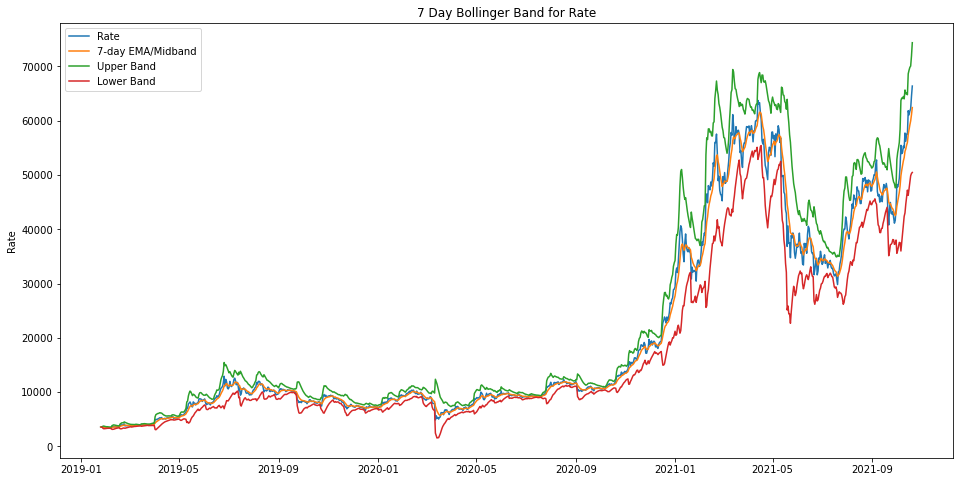

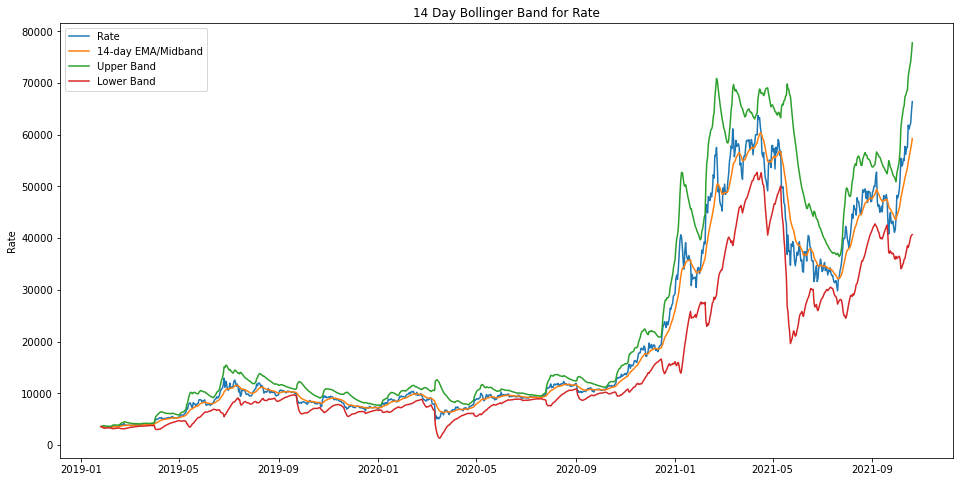

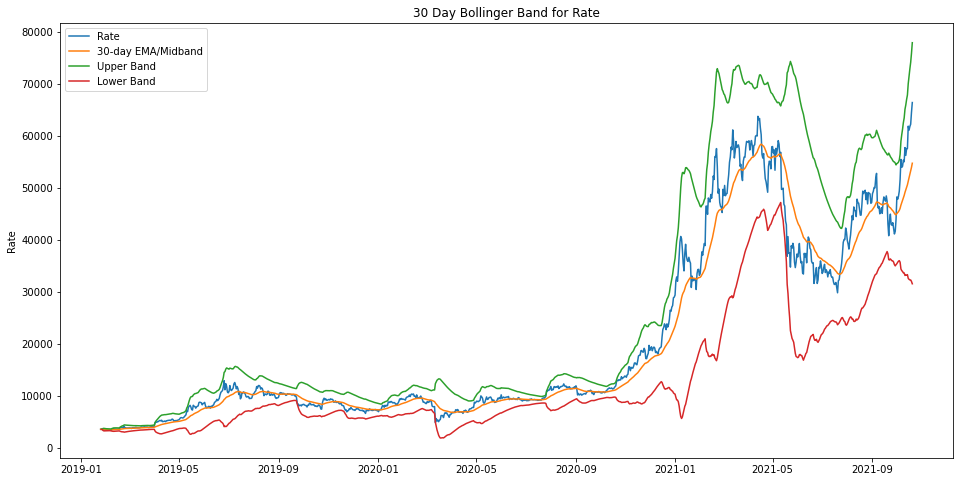

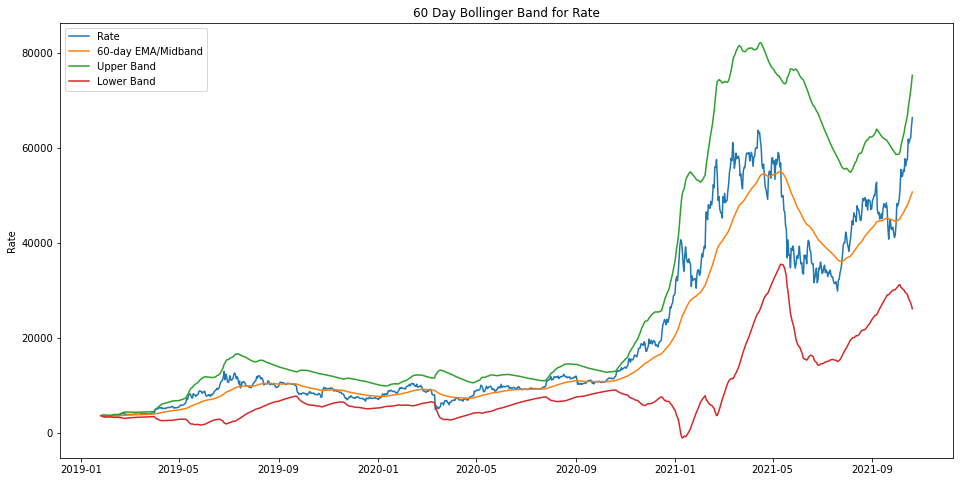

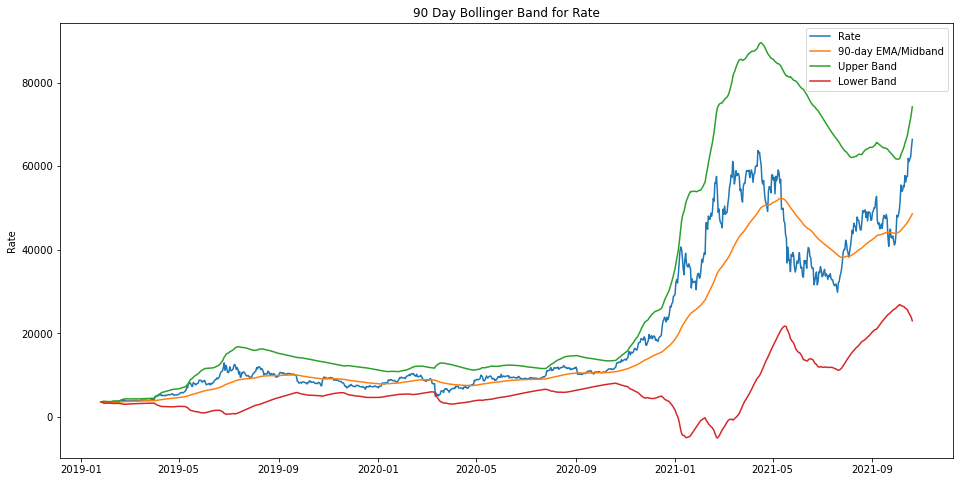

In [7]:
result = generateBollingerBands(daily_btc_df)